## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch.nn.init as init

import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np

## Read the dataset

In [2]:
dataset = read_epochs_dataset('../data/multimodal.pt')

train, test = torch.utils.data.random_split(dataset, [.7, .3])
X, y = next(iter(DataLoader(test, len(test))))

In [4]:
X.shape

torch.Size([282, 204, 301])

## Create a model, inheriting from the BaseModel class.
This model has a spatial filtering layer with a choice of each n-th output and a fully connected layer for predicting

In [3]:
class TinyNet(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=False)
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        print(x.shape)
        return self.fc_layer(x)

In [20]:
model = TinyNet(
    204,
    8,
    301,
    10,
    8
)
model(X)

torch.Size([282, 248])


tensor([[ 0.6087, -0.1062, -0.0346,  ...,  0.0242, -0.2382, -0.4801],
        [-0.6949, -0.2009,  0.2891,  ..., -0.1791, -0.1115,  0.2546],
        [-0.0870, -0.0075,  0.5412,  ..., -0.0940, -0.0757,  0.0408],
        ...,
        [ 0.2071,  0.3725,  0.1914,  ..., -0.2252, -0.1032,  0.2327],
        [ 0.1758,  0.3477, -0.3494,  ..., -0.0238, -0.3249,  0.3068],
        [ 0.0213,  0.2374,  0.2826,  ...,  0.7172, -0.1528, -0.2534]],
       grad_fn=<AddmmBackward0>)

In [13]:
import math

def mc_sin(x, n=10):
    out = torch.zeros_like(x).double()
    for i in range(n):
        out += (((-1)**i*x**(2*i + 1))/(math.factorial(2*i + 1))).double()
    return out

def mc_cos(x, n=10):
    out = torch.zeros_like(x).double()
    for i in range(n):
        out += (((-1)**i*x**(2*i))/(math.factorial(2*i))).double()
    return out

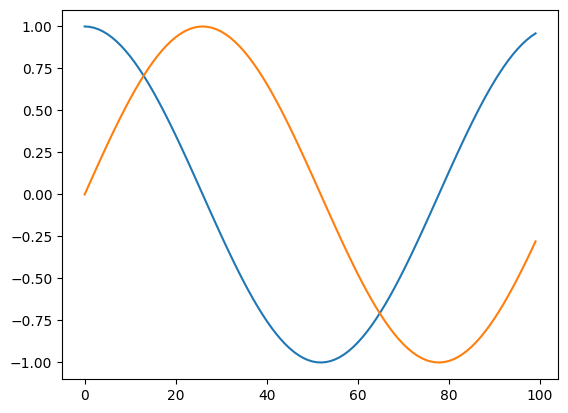

In [165]:
t = torch.Tensor(np.linspace(0, 6, 100))

s = mc_cos(t, 10)

plt.plot(s.numpy())
plt.plot(np.sin(t))
# plt.ylim(-1, 1)

In [4]:
class Fourier(nn.Module):
    def __init__(self, n_points, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.a = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.b = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.a0 = nn.Parameter(torch.empty(self.n_points, 1))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.a, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        init.uniform_(self.a0, -0.01, 0.01)

    def forward(self, x):
        out = (x@self.a0)/(2*self.n_points)*torch.ones_like(x)

        for n in range(self.n_components):
            # out += (x@self.a[:, n])*mc_cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*mc_sin((2*np.pi*x*n)/self.n_points)
            out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*torch.sin((2*np.pi*x*n)/self.n_points)

        return out


class FourierNet(BaseModel):

    def __init__(self, n_points, n_components):
        super().__init__()
        self.layer = Fourier(n_points, n_components)
        self.bn = nn.BatchNorm1d(n_points)

    def forward(self, x):
        x = self.bn(x)
        x = self.layer(x)
        return x

In [15]:
import sys

class Fourier(nn.Module):
    def __init__(self, n_points, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.a = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.b = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.a0 = nn.Parameter(torch.empty(self.n_points, 1))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.a, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        init.uniform_(self.a0, -0.01, 0.01)

    def forward(self, x):
        out = (x@self.a0)/(2*self.n_points)*torch.ones_like(x)

        for n in range(self.n_components):
            # out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*torch.sin((2*np.pi*x*n)/self.n_points)
            # out = out + x@self.a[:, n]*torch.cos(x)
            # out.add_(x@self.a[:, n]*torch.cos(x))
            out += (x@self.a[:, n])*mc_cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*mc_sin((2*np.pi*x*n)/self.n_points)

        return out


class Branch(nn.Module):

    def __init__(
        self,
        n_channels: int,
        n_components: int
    ):
        super().__init__()
        self.unmixing_layer = Fourier(n_channels, n_components)


    def forward(self, x: torch.Tensor):
        x_dmx = torch.zeros((x.shape[0], x.shape[-1]))

        for timepoint in range(
            x.shape[-1]
        ):
            x_dmx[:, timepoint] = (x[:, :, timepoint]*self.unmixing_layer(x[:, :, timepoint])).sum(1)
        return x_dmx

In [11]:
b = Branch(204, 15)

In [16]:
with torch.no_grad():
    out = b(X)

In [17]:
out = b(X)

KeyboardInterrupt: 

In [22]:
sys.getsizeof(b.unmixing_layer.layer.b)

72

In [14]:
from copy import deepcopy

In [11]:

g_2 = globals()



In [ ]:
for (name, val1), val2 in zip(g_1.items(), g_2.values()):
    print(name, sys.getsizeof(val1), sys.getsizeof(val2))

In [16]:
del out

In [14]:
model.unmixing_layer[0].

Fourier()

In [ ]:
out.shape

torch.Size([282, 1, 301])

In [29]:
torch.empty((1, 2))

tensor([[2.1484e-32, 4.5716e-41]])

In [5]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

## Compile the model

In [1]:
import sys

class Net(BaseModel):

    def __init__(
        self,
        n_channels: int,
        filter_size: int,
        n_latent: int,
        n_times: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.n_latent = n_latent
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.ModuleList([
            # FourierNet(n_channels, n_components)
            nn.Sequential(
                # nn.BatchNorm1d(n_channels),
                nn.Linear(n_channels, n_channels),
                nn.Dropout(.5),
                nn.BatchNorm1d(n_channels),
            )
            for _ in range(n_latent)])
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor+1)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x_dmx = torch.zeros((x.shape[0], self.n_latent, x.shape[-1]))

        for n_latent in range(self.n_latent):
            for timepoint in range(
                x.shape[-1]
            ):
                x_dmx[:, n_latent, timepoint] = (x[:, :, timepoint]*self.unmixing_layer[n_latent](x[:, :, timepoint])).sum(1)
        x = self.unmixing_layer(x_dmx)
        x = x_dmx[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

NameError: name 'BaseModel' is not defined

In [12]:
import sys

class Net(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_components: int,
        filter_size: int,
        n_latent: int,
        n_times: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.n_latent = n_latent
        self.pool_factor = pool_factor
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.transform = nn.ModuleList([
            FourierNet(n_times, n_components)
            for _ in range(n_channels)])
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=False)
        final_out_features = (n_times//pool_factor+1)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        print(final_out_features)
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        # x_dmx = torch.zeros((x.shape[0], self.n_latent, x.shape[-1]))
        # x = self.temp_conv(x)
        x_dmx = torch.zeros_like(x)

        for channel in range(
            x.shape[-2]
        ):
            x_dmx[:, channel, :] = self.transform[channel](x[:, channel, :])
        x_dmx = self.unmixing_layer(x_dmx)
        x_dmx = self.temp_conv(x_dmx)
        x = x_dmx[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)

        return self.fc_layer(x)

In [13]:
model = Net(
    n_channels=204, # ~ number of channels (gradiometers)
    n_components=10,
    filter_size=50,
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

model(X)

248


: 

: 

In [3]:
import numpy as np

a = np.random.random((10, 10))
a1 = np.linalg.inv(a)
b = np.random.random((10, 1))

c = a@b
b

array([[0.83929558],
       [0.03118327],
       [0.141113  ],
       [0.37120237],
       [0.95520101],
       [0.48054887],
       [0.26892405],
       [0.27089759],
       [0.7677174 ],
       [0.89419446]])

In [4]:
a1@c

array([[0.83929558],
       [0.03118327],
       [0.141113  ],
       [0.37120237],
       [0.95520101],
       [0.48054887],
       [0.26892405],
       [0.27089759],
       [0.7677174 ],
       [0.89419446]])

In [10]:
# model = TinyNet(
#     n_channels=204, # ~ number of channels (gradiometers)
#     n_latent=8, # ~ number of latent factors
#     n_times=301, # ~ number of samples in epoch after preprocessing
#     pool_factor=10, # ~ take each 10th sample from spatially filtered components
#     n_outputs=8 # ~ number of output classes (number of events in epochs)
# )
model = Net(
    n_channels=204, # ~ number of channels (gradiometers)
    n_components=10,
    filter_size=50,
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

# if you want to define optimizer, do not forget to specify model parameters (e.g., torch.optim.Adam(model.parameters()))
optimizer = torch.optim.Adam

loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

# in model compilation two callbacks are used: PrintingCallback is used to print training history and EarlyStopping is used to prevent overfitting
model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        # EarlyStopping(monitor='loss_val', patience=15, restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        )
        # L2Reg(
        #     [
        #         # *[f'unmixing_layer.{i}.1.weight' for i in range(8)],
        #         *[f'unmixing_layer.{i}.0.weight' for i in range(8)],
        #         # 'temp_conv.weight'
        #     ],
        #     lambdas=.1
        # )
    ]
)

248


## Training the model

In [ ]:
model.state_dict().keys()

Epoch 0:  loss_train:  0.7584   |    binary_accuracy_train:  0.5841   |    loss_val:  0.7252   |    binary_accuracy_val:  0.6767
Epoch 1:  loss_train:  0.5673   |    binary_accuracy_train:  0.8040   |    loss_val:  0.5917   |    binary_accuracy_val:  0.8155
Epoch 2:  loss_train:  0.3709   |    binary_accuracy_train:  0.9290   |    loss_val:  0.4325   |    binary_accuracy_val:  0.8834
Epoch 3:  loss_train:  0.2406   |    binary_accuracy_train:  0.9592   |    loss_val:  0.4116   |    binary_accuracy_val:  0.8901
Epoch 4:  loss_train:  0.1772   |    binary_accuracy_train:  0.9780   |    loss_val:  0.4151   |    binary_accuracy_val:  0.8936
Epoch 5:  loss_train:  0.1364   |    binary_accuracy_train:  0.9932   |    loss_val:  0.4131   |    binary_accuracy_val:  0.8997
Epoch 6:  loss_train:  0.1181   |    binary_accuracy_train:  0.9985   |    loss_val:  0.4253   |    binary_accuracy_val:  0.9012
Epoch 7:  loss_train:  0.1088   |    binary_accuracy_train:  0.9994   |    loss_val:  0.4573   | 

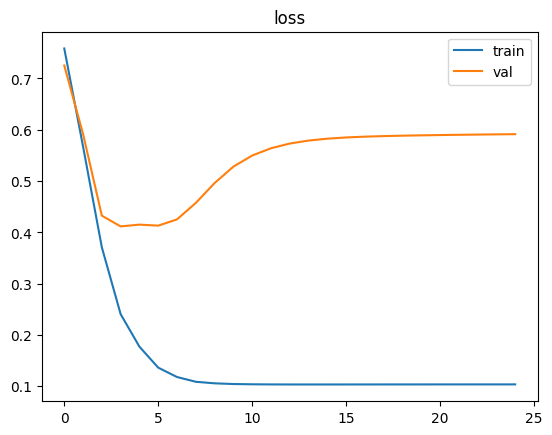

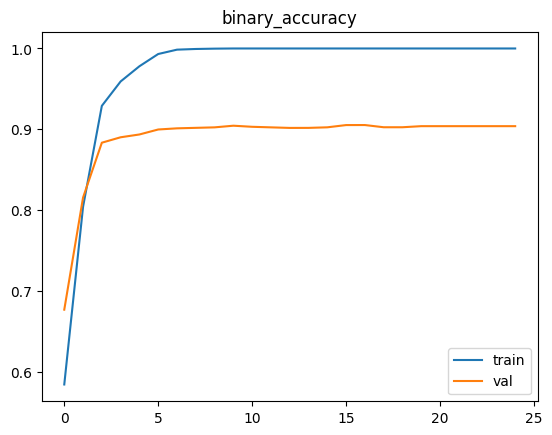

In [11]:
history = model.fit(train, n_epochs=25, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [30]:
# lfcnn
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1532405303283171
train_binary_accuracy: 0.978103144602342
loss: 0.5699232030998577
binary_accuracy: 0.9046266241507097


In [11]:
# Spatial Net

train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 6.881107763810591
train_binary_accuracy: 0.968291082165458
loss: 7.6230246803977275
binary_accuracy: 0.858360388062217


In [16]:
# Spatial Temp Net

train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.850511144508015
train_binary_accuracy: 0.9644230712543834
loss: 1.3321604186838323
binary_accuracy: 0.8547077937559648


## Make prediction

#### Take a random sample from the test set

In [50]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

Sample 130


#### Make a prediction, print the predicted value and the actual label

In [51]:
y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Prediction:  1.21 | -0.31 |  0.11 | -2.77 |  0.48 |  3.39 | -0.74 | -1.76
Actual:      0.0  |  0.0  |  0.0  |  0.0  |  0.0  |  1.0  |  0.0  |  0.0 


## Save model weights

In [52]:
# make sure that this path exists!
model.save('../models/tinynet.pt')

## Create a new model and load weights

In [53]:
other_model = TinyNet(204, 8, 301, 10, 8)
other_model.load('../models/tinynet.pt')

## Evaluate the loaded model

In [55]:
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

# To make predictions and estimate loss, we only need to compile them. We don't need the rest of the parameters
other_model.compile(
    loss=loss,
    metrics=metric
)

train_result = other_model.evaluate(train)
result = other_model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.4911928854205392
train_binary_accuracy: 0.7855550700967963
loss: 0.5828646475618536
binary_accuracy: 0.6903409145095132


## Continue training

#### Recompile the model with new parameters

In [58]:
optimizer = torch.optim.AdamW(other_model.parameters(), lr=3e-3, eps=1e-10) # Let's make another optimizer, and define it
loss = torch.nn.CrossEntropyLoss() # Let's try another loss function

other_model.compile(
    optimizer,
    loss,
    metric, # We do not change metric
    callbacks=[
        PrintingCallback(), # Callback for printing
        EarlyStopping(
            monitor='loss_val'
        ), # Callback for early stopping, but with restoring weights
        L2Reg(
            [ # to see list of layer names use list(model.state_dict().keys())
                'unmixing_layer.weight',
                'fc_layer.weight',
                'fc_layer.bias'
            ],
            [ # different lambda value for different layers
                .01,
                .005,
                .0001
            ]
        ) # l2 regularization for specified layers
    ]
)

#### Fit the model with new training parameters

Epoch 0:  loss_train:  0.5246   |    binary_accuracy_train:  0.7828   |    loss_val:  0.4643   |    binary_accuracy_val:  0.7699
Epoch 1:  loss_train:  0.3635   |    binary_accuracy_train:  0.7753   |    loss_val:  0.4525   |    binary_accuracy_val:  0.7519
Epoch 2:  loss_train:  0.2779   |    binary_accuracy_train:  0.7723   |    loss_val:  0.4481   |    binary_accuracy_val:  0.7368
Epoch 3:  loss_train:  0.2218   |    binary_accuracy_train:  0.7697   |    loss_val:  0.4466   |    binary_accuracy_val:  0.7328
Epoch 4:  loss_train:  0.1819   |    binary_accuracy_train:  0.7647   |    loss_val:  0.4490   |    binary_accuracy_val:  0.7274
Epoch 5:  loss_train:  0.1526   |    binary_accuracy_train:  0.7656   |    loss_val:  0.4531   |    binary_accuracy_val:  0.7192
Epoch 6:  loss_train:  0.1308   |    binary_accuracy_train:  0.7631   |    loss_val:  0.4558   |    binary_accuracy_val:  0.7163
Epoch 7:  loss_train:  0.1143   |    binary_accuracy_train:  0.7665   |    loss_val:  0.4573   | 

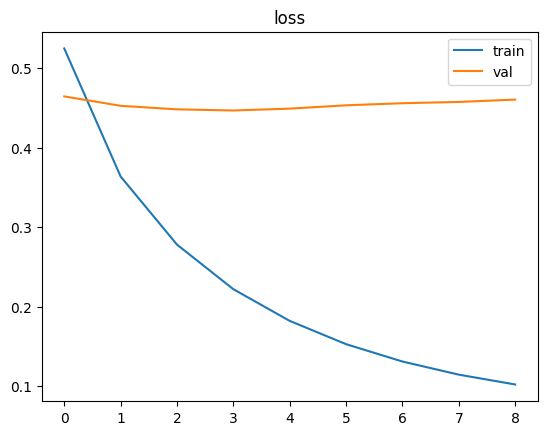

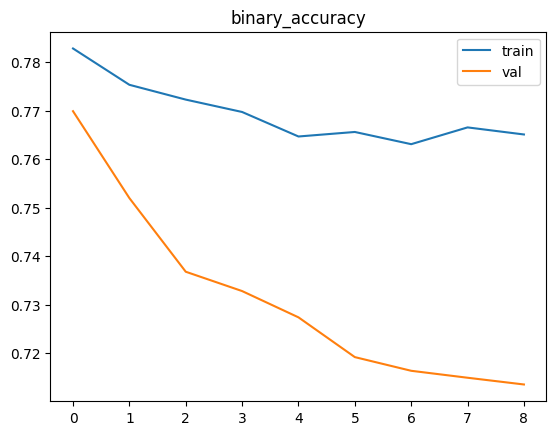

In [59]:
history = other_model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [60]:
train_result = other_model.evaluate(train)
result = other_model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.2420384558764371
train_binary_accuracy: 0.7594624107534235
loss: 0.626438623124903
binary_accuracy: 0.7065746730024164
